In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import pandas as pd

In [4]:
# import data
data_set_X = np.genfromtxt("hw07_data_set_images.csv", delimiter = ",")
data_set_y = np.genfromtxt("hw07_data_set_labels.csv", delimiter = ",")

split_location = 2000

train_set_X = data_set_X[0:split_location, :]
train_set_y = data_set_y[0:split_location]
test_set_X = data_set_X[split_location : len(data_set_X), :]
test_set_y = data_set_y[split_location : len(data_set_y)]

In [5]:
# retrieve relevant statistics
K = int(np.amax(data_set_y))

means_array = []

for i in range(K + 1):
  this_class = []
  for j in range(len(train_set_X)):
    if i == train_set_y[j]:
      this_class.append(train_set_X[j, :])
  if i != 0:
    this_class = np.array(this_class)
    mean = this_class.mean(0)
    means_array.append(mean)
  
overall_mean = train_set_X.mean(0)

In [6]:
# Calculate SW and SB matrices
SW = 0
for i in range(len(train_set_y)):
  for j in range(K):
    if (j + 1) == train_set_y[i]:
      xi = train_set_X[i, :]
      mj = means_array[j]
      # in this case the transpose variable represents the D x 1 vector
      difference = np.array([xi - mj])
      difference_transpose = difference.T
      SW += np.matmul(difference_transpose, difference)

SB = 0
for i in range(len(train_set_y)):
  for j in range(K):
    if (j + 1) == train_set_y[i]:
      mj = means_array[j]
      # in this case the transpose variable represents the D x 1 vector
      difference = np.array([mj - overall_mean])
      difference_transpose = difference.T
      SB += np.matmul(difference_transpose, difference)

print(SW[0:4, 0:4])
print(SB[0:4, 0:4])

[[  195.0531401    138.98550725   138.24154589   273.64251208]
 [  138.98550725   146.68407152   137.97108222   212.80522823]
 [  138.24154589   137.97108222   237.79940915   222.04558827]
 [  273.64251208   212.80522823   222.04558827 10381.73114607]]
[[ 0.8488599   0.86049275  1.26145411  4.64248792]
 [ 0.86049275  1.07392848  2.24791778  8.49977177]
 [ 1.26145411  2.24791778  6.68009085 25.25691173]
 [ 4.64248792  8.49977177 25.25691173 97.25635393]]


In [7]:
# retrieve the eigenvectors and eigenvalues
SW_inverse = np.linalg.inv(SW)
SW_inv_times_SB = np.matmul(SW_inverse, SB)

eigenvalues, eigenvectors = np.linalg.eig(SW_inv_times_SB)
eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

print(eigenvalues[0:9])

[26.03085646 11.57909822  7.86259994  5.12082313  3.60002676  3.22503144
  2.71288241  1.3688596   1.13340931]


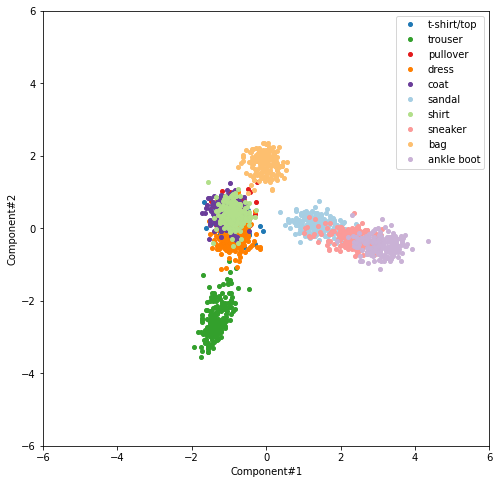

In [8]:
# project thetraining and test data points in a two-dimensional subspace
# using the two eigenvectors that correspond to the largest two eigenvalues

first_two_eigenvectors = eigenvectors[:,[0, 1]].T

point_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6"])
labels = ["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]


# plot training data points
plt.figure(figsize = (8, 8))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
for j in range(K):
  train_component_one_values = []
  train_component_two_values = []
  for i in range(len(train_set_y)):
    if train_set_y[i] == (j + 1):
      xi = train_set_X[i, :]
      xi_minus_mean = np.array(xi - overall_mean).T
      zi = np.matmul(first_two_eigenvectors, xi_minus_mean)
      train_component_one_values.append(zi[0])
      train_component_two_values.append(zi[1])
  plt.plot(train_component_one_values, train_component_two_values, marker = 'o', linestyle = "none", color = point_colors[j], markersize = 4, label = labels[j])
plt.xlabel("Component#1")
plt.ylabel("Component#2")
plt.legend()

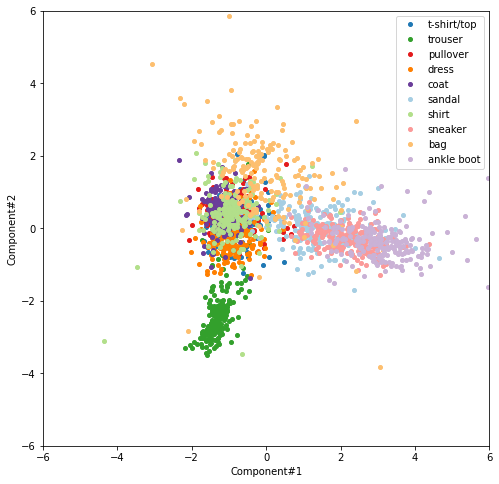

In [9]:
# plot testing data points
plt.figure(figsize = (8, 8))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
for j in range(K):
  test_component_one_values = []
  test_component_two_values = []
  for i in range(len(test_set_y)):
    if test_set_y[i] == (j + 1):
      xi = test_set_X[i, :]
      xi_minus_mean = np.array(xi - overall_mean).T
      zi = np.matmul(first_two_eigenvectors, xi_minus_mean)
      test_component_one_values.append(zi[0])
      test_component_two_values.append(zi[1])
  plt.plot(test_component_one_values, test_component_two_values, marker = 'o', linestyle = "none", color = point_colors[j], markersize = 4, label = labels[j])
plt.xlabel("Component#1")
plt.ylabel("Component#2")
plt.legend()

In [13]:
# print confusion matrix for subspace from largest 9 eigenvalues for train data
first_nine_eigenvectors = eigenvectors[:,[0, 1, 2, 3, 4, 5, 6, 7, 8]].T

z_matrix_train = []

for i in range(len(train_set_X)):
  xi = train_set_X[i, :]
  xi_minus_mean = np.array(xi - overall_mean).T
  zi = np.matmul(first_nine_eigenvectors, xi_minus_mean)
  z_matrix_train.append(zi)

z_matrix_train = np.array(z_matrix_train)
distances_z_train = spatial.distance.cdist(z_matrix_train, z_matrix_train)

k = 11
score = np.zeros((len(train_set_X), K))

for c in range(K):
  score[:, c] = np.asarray([np.sum(train_set_y[np.argsort(distances_z_train[x, :])[range(k)]] == (c + 1)) for x in range(len(train_set_X))]) / k

y_predicted_train = []

for row in score:
  index = np.argmax(row)
  for c in range(K):
    if c == index:
      y_predicted_train.append(index + 1)

confusion_matrix_train = pd.crosstab(np.reshape(y_predicted_train, len(train_set_X)), train_set_y,
                               rownames = ["y_predicted"], colnames = ["y_train"])

print(confusion_matrix_train)

y_train      1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0
y_predicted                                                            
1             203     0     1     1     0     0    15     0     0     0
2               0   192     0     1     0     0     0     0     0     0
3               0     0   198     0     3     0    11     0     0     0
4               2     2     1   202     3     0     4     0     0     0
5               0     0     8     1   201     0     9     0     0     0
6               0     0     0     0     0   175     0     3     0     0
7               9     0     2     6    11     0   168     0     1     0
8               0     0     0     0     0     3     0   196     0     1
9               0     0     0     0     0     0     0     0   183     0
10              0     0     0     0     0     0     0     0     0   184


In [14]:
# print confusion matrix for subspace from largest 9 eigenvalues for test data
z_matrix_test = []

for i in range(len(train_set_X)):
  xi = test_set_X[i, :]
  xi_minus_mean = np.array(xi - overall_mean).T
  zi = np.matmul(first_nine_eigenvectors, xi_minus_mean)
  z_matrix_test.append(zi)

z_matrix_test = np.array(z_matrix_test)
distances_z_test = spatial.distance.cdist(z_matrix_test, z_matrix_test)

k = 11
score = np.zeros((len(test_set_X), K))

for c in range(K):
  score[:, c] = np.asarray([np.sum(test_set_y[np.argsort(distances_z_test[x, :])[range(k)]] == (c + 1)) for x in range(len(test_set_X))]) / k

y_predicted_test = []

for row in score:
  index = np.argmax(row)
  for c in range(K):
    if c == index:
      y_predicted_test.append(index + 1)

confusion_matrix_test = pd.crosstab(np.reshape(y_predicted_test, len(test_set_X)), test_set_y,
                               rownames = ["y_predicted"], colnames = ["y_test"])

print(confusion_matrix_test)

y_test       1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0
y_predicted                                                            
1             154     0    16     7     2     2    40     0     5     0
2               0   182     1     2     1     0     0     0     0     0
3               8     3   137     2    25     0    24     0     0     0
4              12     3     4   174    10     1    12     0     6     0
5               2     0    32     5   151     2    29     0     0     1
6               0     0     2     1     0   136     1    17    13    11
7              14     0     9     6     9     2    98     0     3     0
8               0     0     0     1     0    33     0   174     2    16
9               5     1     4     2     1     8     8     0   155     1
10              0     0     0     0     0    18     1    13     4   176
